1.What is the difference between Correlation and 
Causation?  
- Correlation
    - two variables tend to change together
    - but it doesn't necessarily mean that changes in one variable cause
    changes in the other
- Causation
    - If one variable's changes directly lead to changes in another

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
data = pd.read_csv(filepath_or_buffer="./creditworthiness.csv")
data = data[data["_TREATMENT"] >= 0] # removing control group and not part of experiment

3. What is the difference between Causality vs. 
Prediction?  
- Prediction
  - many machine learning techniques focus on prediction (what is the
  outcome)
  - Causal inference
  - aims to uncover the mechanisms underlying the data generation
- process
  - forecasting future outcomes + understanding why and how
  things happen

In [3]:
pct_s = (
    data[data.IS_DEFAULT == 1].groupby(["_TREATMENT"]).size()
    / data.groupby(["_TREATMENT"]).size()
)
print("Percentage for each group that defaulted\n", pct_s)

Percentage for each group that defaulted
 _TREATMENT
0    0.350365
1    0.226277
2    0.317518
3    0.204380
dtype: float64


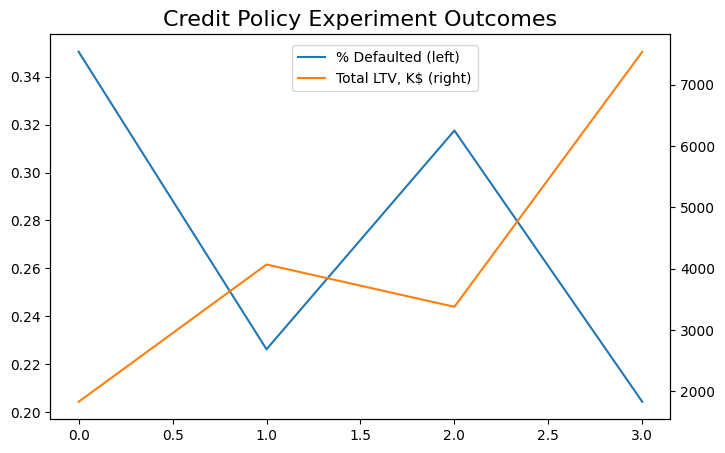

In [4]:
ltv_s = data.groupby(["_TREATMENT"])["_LTV"].sum() / 1000

treatment_names = [
    "Lower Credit Limit",
    "Payment Plan",
    "Payment Plan &\nLower Credit Limit",
]
all_treatment_names = np.array(["None"] + treatment_names)

plot_df = pd.DataFrame({'% Defaulted (left)':pct_s, 'Total LTV, K$':ltv_s})
plot_df.index = all_treatment_names
plot_df = plot_df.reset_index()

ax = plot_df.plot(secondary_y=['Total LTV, K$'], figsize=(8,5))
ax.get_legend().set_bbox_to_anchor((0.7, 0.99))
plt.grid(False)
plt.title("Credit Policy Experiment Outcomes", fontsize=16)
plt.show()

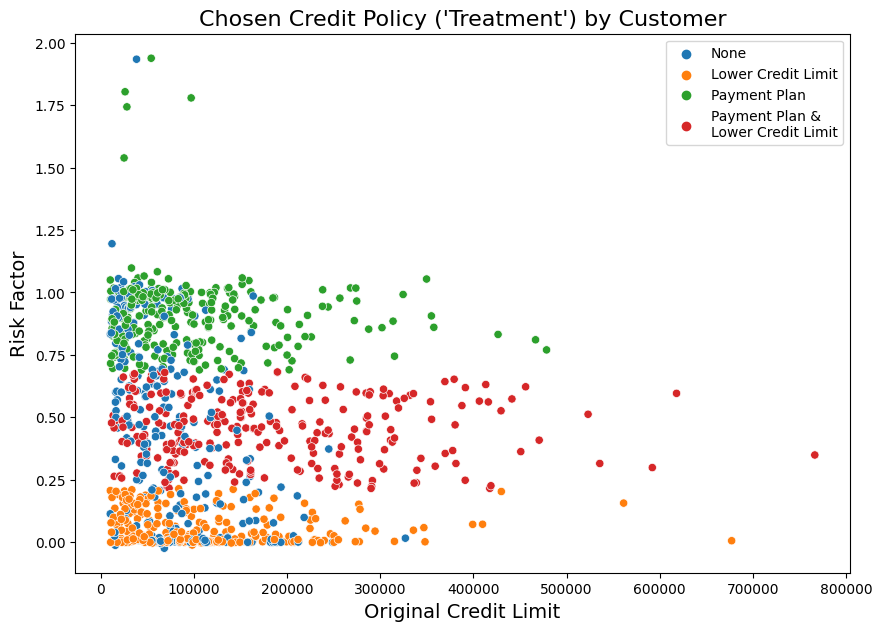

In [5]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
x=data['_CC_LIMIT'].values,
y=data['_risk_score'].values,
hue=all_treatment_names[data['_TREATMENT'].values],
hue_order=all_treatment_names
)
plt.title("Chosen Credit Policy ('Treatment') by Customer", fontsize=16)
plt.xlabel("Original Credit Limit", fontsize=14)
plt.ylabel("Risk Factor", fontsize=14)
plt.show()

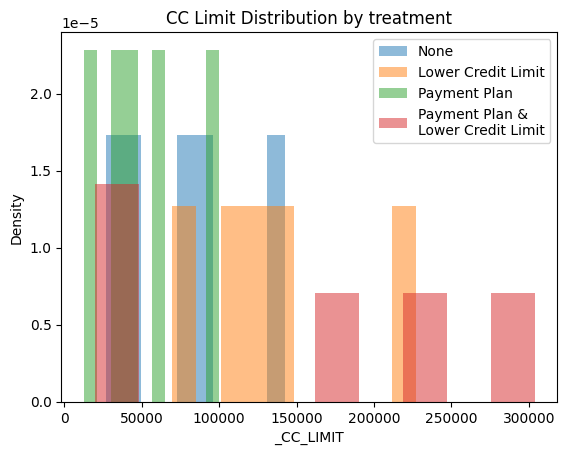

In [6]:
kwargs = dict(alpha=0.5, bins=10, density=True)
i = 0
for name in all_treatment_names:
    x = data[data._TREATMENT == i]["_CC_LIMIT"][:5].values
    plt.hist(x, **kwargs, label=name)
    i += 1
plt.xlabel("_CC_LIMIT")
plt.ylabel("Density")
plt.title("CC Limit Distribution by treatment")
plt.legend()
plt.show()

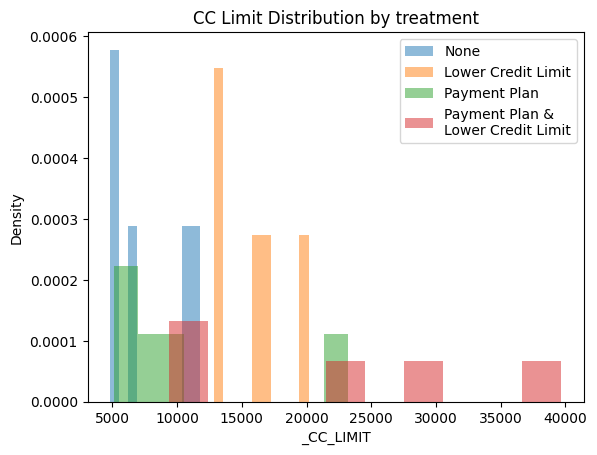

In [7]:
kwargs = dict(alpha=0.5, bins=10, density=True)
i = 0
for name in all_treatment_names:
    x = data[data._TREATMENT == i]["_LTV"][:5].values
    plt.hist(x, **kwargs, label=name)
    i += 1
plt.xlabel("_CC_LIMIT")
plt.ylabel("Density")
plt.title("CC Limit Distribution by treatment")
plt.legend()
plt.show()

In [8]:
Y = data[['_LTV']]
T = data[['_TREATMENT']]
X = data[['_CC_LIMIT']]
W = data[['_spend','_tpm','_ppm','_RETAIL','_URBAN','_RURAL','_PREMIUM']]

In [9]:
from econml.dr import LinearDRLearner
import xgboost as xgb

drlearner = LinearDRLearner(
    model_regression=xgb.XGBRegressor(learning_rate=0.1),
    model_propensity=xgb.XGBClassifier(
        learning_rate=0.1, max_depth=2, objective="multi:softmax"
    ),
)

/home/eon/miniconda3/envs/bio/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/eon/miniconda3/envs/bio/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_orde

In [10]:
causal_mdl = drlearner.dowhy.fit(
    Y,
    T,
    X=X,
    W=W,
    outcome_names=Y.columns.to_list(),
    treatment_names=T.columns.to_list(),
    feature_names=X.columns.to_list(),
    confounder_names=W.columns.to_list(),
    target_units=X.iloc[:550].values,
)
identified_ate = causal_mdl.identified_estimand_
print(identified_ate)
drlearner_estimate = causal_mdl.estimate_
print(drlearner_estimate)
idxs = np.arange(0, causal_mdl._d_t[0]) # 3 TREATMENTS
print("idxs\n",idxs)
coefs = np.hstack([causal_mdl.coef_(T=i+1) for i in idxs])
print("coefs\n",coefs)
intercepts = np.hstack([causal_mdl.intercept_(T=i+1) for i in idxs])
print("intercepts\n",intercepts)

econml has not been tested with dowhy versions >= 0.9
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
─────────────(E[_LTV|_CC_LIMIT,_PREMIUM,_spend,_URBAN,_ppm,_RETAIL,_tpm,_RURAL
d[_TREATMENT]                                                                 

  
])
  
Estimand assumption 1, Unconfoundedness: If U→{_TREATMENT} and U→_LTV then P(_LTV|_TREATMENT,_CC_LIMIT,_PREMIUM,_spend,_URBAN,_ppm,_RETAIL,_tpm,_RURAL,U) = P(_LTV|_TREATMENT,_CC_LIMIT,_PREMIUM,_spend,_URBAN,_ppm,_RETAIL,_tpm,_RURAL)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
─────────────(E[_LTV|_CC_LIMIT,_PREMIUM,_

In [12]:
for i in range(causal_mdl._d_t[0]):
    print("Treatment: %s" % treatment_names[i])
    display(causal_mdl.summary(T=i+1))
    print("\r\n")

Treatment: Lower Credit Limit


This call is ambiguous, we're defaulting to CATE estimator's attribute. Please add 'dowhy__' as prefix if you want to get dowhy attribute.


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
_CC_LIMIT,0.013,0.018,0.689,0.491,-0.023,0.048
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,5901.912,1109.874,5.318,0.0,3726.6,8077.225




Treatment: Payment Plan


This call is ambiguous, we're defaulting to CATE estimator's attribute. Please add 'dowhy__' as prefix if you want to get dowhy attribute.


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
_CC_LIMIT,0.039,0.018,2.18,0.029,0.004,0.075
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,1226.304,1088.696,1.126,0.26,-907.5,3360.109




Treatment: Payment Plan &
Lower Credit Limit


This call is ambiguous, we're defaulting to CATE estimator's attribute. Please add 'dowhy__' as prefix if you want to get dowhy attribute.


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
_CC_LIMIT,0.062,0.018,3.499,0.0,0.027,0.097
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,5524.562,1147.221,4.816,0.0,3276.05,7773.073


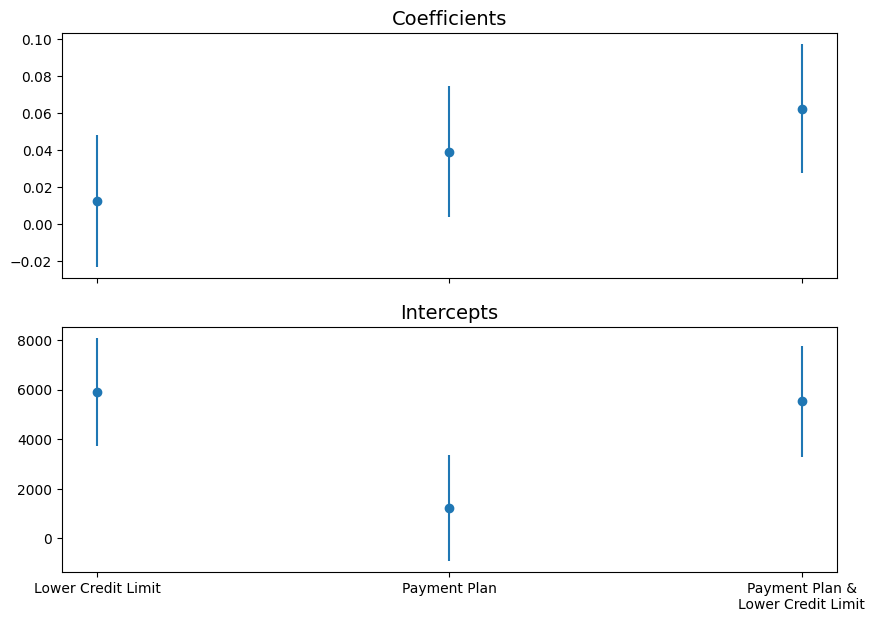

In [13]:
idxs = np.arange(0, causal_mdl._d_t[0])
coefs = np.hstack([causal_mdl.coef_(T=i + 1) for i in idxs])
intercepts = np.hstack([causal_mdl.intercept_(T=i + 1) for i in idxs])
coefs_err = np.hstack([causal_mdl.coef__interval(T=i + 1) for i in idxs])
coefs_err[0, :] = coefs - coefs_err[0, :]
coefs_err[1, :] = coefs_err[1, :] - coefs
intercepts_err = np.vstack([causal_mdl.intercept__interval(T=i + 1) for i in idxs]).T
intercepts_err[0, :] = intercepts - intercepts_err[0, :]
intercepts_err[1, :] = intercepts_err[1, :] - intercepts
plt.figure(figsize=(10, 7))
ax1 = plt.subplot(2, 1, 1)
plt.errorbar(idxs, coefs, coefs_err, fmt="o")
plt.xticks(idxs, treatment_names)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.title("Coefficients", fontsize=14)
plt.subplot(2, 1, 2)
plt.errorbar(idxs, intercepts, intercepts_err, fmt="o")
plt.xticks(idxs, treatment_names)
plt.title("Intercepts", fontsize=14)
plt.show()

In [17]:
cost_fn = lambda X: np.repeat(np.array([[0, 100, 100]]), X.shape[0], axis=0) + (
    np.repeat(np.array([[30, 0, 30]]), X.shape[0], axis=0)
    * X._ppm.values.reshape(-1, 1)
)

In [18]:
treatment_effect_minus_costs = causal_mdl.const_marginal_effect(X=X.values) -\
cost_fn(data)
treatment_effect_minus_costs = np.hstack([np.zeros(X.shape), treatment_effect_minus_costs])
recommended_T = np.argmax(treatment_effect_minus_costs, axis=1)

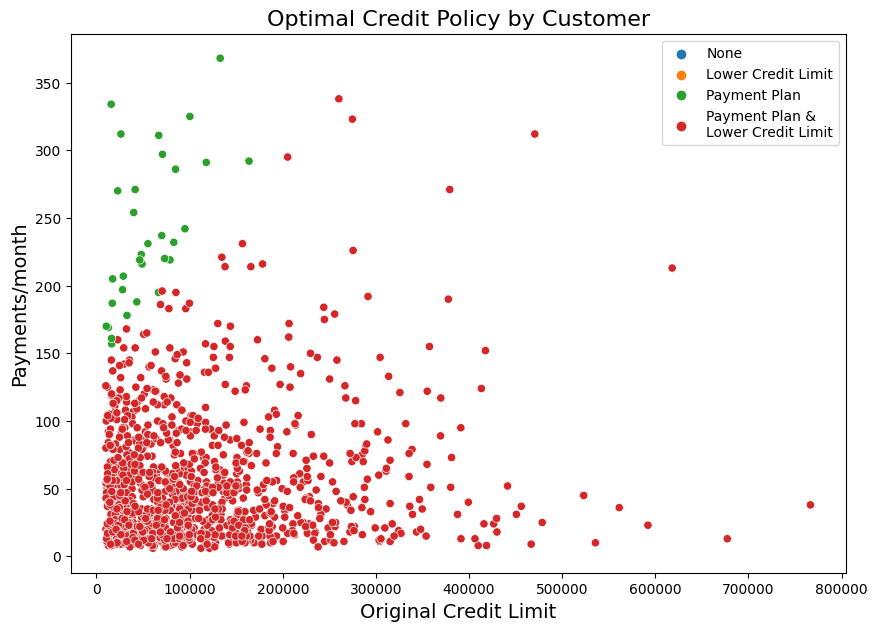

In [19]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=data["_CC_LIMIT"].values,
    y=data["_ppm"].values,
    hue=all_treatment_names[recommended_T],
    hue_order=all_treatment_names,
)
plt.title("Optimal Credit Policy by Customer", fontsize=16)
plt.xlabel("Original Credit Limit", fontsize=14)
plt.ylabel("Payments/month", fontsize=14)
plt.show()

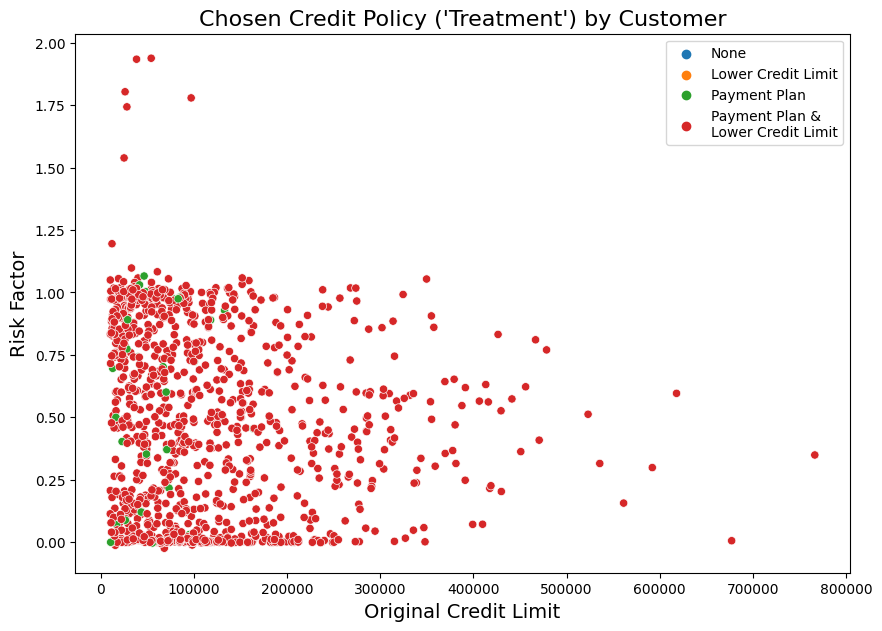

In [20]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
x=data['_CC_LIMIT'].values,
y=data['_risk_score'].values,
hue=all_treatment_names[recommended_T],
hue_order=all_treatment_names
)
plt.title("Chosen Credit Policy ('Treatment') by Customer", fontsize=16)
plt.xlabel("Original Credit Limit", fontsize=14)
plt.ylabel("Risk Factor", fontsize=14)
plt.show()

In [21]:
ref_random = causal_mdl.refute_estimate(method_name="random_common_cause")
print("ref_random\n",ref_random)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

ref_random
 Refute: Add a random common cause
Estimated effect:7316.576841151527
New effect:7470.7411033264625
p value:0.94



In [22]:
ref_placebo = causal_mdl.refute_estimate(
    method_name="placebo_treatment_refuter", placebo_type="permute", num_simulations=20
)
print("ref_placebo\n", ref_placebo)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

ref_placebo
 Refute: Use a Placebo Treatment
Estimated effect:7316.576841151527
New effect:151.71329849369573
p value:0.38570219959386487



In [23]:
res_subset = causal_mdl.refute_estimate(
    method_name="data_subset_refuter", subset_fraction=0.9
)
print("res_subset", res_subset)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

res_subset Refute: Use a subset of data
Estimated effect:7316.576841151527
New effect:7107.364811505311
p value:0.72



Use AGE_GROUP as confounder

In [24]:
Y = data[['_LTV']]
T = data[['_TREATMENT']]
X = data[['_CC_LIMIT']]
W = data[['_spend','_tpm','_ppm','_RETAIL','_URBAN','_RURAL','_PREMIUM','AGE_GROUP']]

In [25]:
causal_mdl = drlearner.dowhy.fit(
    Y,
    T,
    X=X,
    W=W,
    outcome_names=Y.columns.to_list(),
    treatment_names=T.columns.to_list(),
    feature_names=X.columns.to_list(),
    confounder_names=W.columns.to_list(),
    target_units=X.iloc[:550].values,
)
identified_ate = causal_mdl.identified_estimand_
print(identified_ate)
drlearner_estimate = causal_mdl.estimate_
print(drlearner_estimate)
idxs = np.arange(0, causal_mdl._d_t[0]) # 3 TREATMENTS
print("idxs\n",idxs)
coefs = np.hstack([causal_mdl.coef_(T=i+1) for i in idxs])
print("coefs\n",coefs)
intercepts = np.hstack([causal_mdl.intercept_(T=i+1) for i in idxs])
print("intercepts\n",intercepts)

econml has not been tested with dowhy versions >= 0.9
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
─────────────(E[_LTV|_CC_LIMIT,_PREMIUM,_spend,_URBAN,_ppm,_RETAIL,_tpm,_RURAL
d[_TREATMENT]                                                                 

            
,AGE_GROUP])
            
Estimand assumption 1, Unconfoundedness: If U→{_TREATMENT} and U→_LTV then P(_LTV|_TREATMENT,_CC_LIMIT,_PREMIUM,_spend,_URBAN,_ppm,_RETAIL,_tpm,_RURAL,AGE_GROUP,U) = P(_LTV|_TREATMENT,_CC_LIMIT,_PREMIUM,_spend,_URBAN,_ppm,_RETAIL,_tpm,_RURAL,AGE_GROUP)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                               

In [27]:
import warnings
warnings.filterwarnings("ignore")
ref_random = causal_mdl.refute_estimate(method_name="random_common_cause")
print("ref_random\n",ref_random)
ref_placebo = causal_mdl.refute_estimate(
    method_name="placebo_treatment_refuter", placebo_type="permute", num_simulations=20
)
print("ref_placebo\n", ref_placebo)
res_subset = causal_mdl.refute_estimate(
    method_name="data_subset_refuter", subset_fraction=0.9
)
print("res_subset", res_subset)

ref_random
 Refute: Add a random common cause
Estimated effect:7040.011042093456
New effect:7269.7289031985565
p value:0.8999999999999999

ref_placebo
 Refute: Use a Placebo Treatment
Estimated effect:7040.011042093456
New effect:-4.136592585668882
p value:0.49741580237663796

res_subset Refute: Use a subset of data
Estimated effect:7040.011042093456
New effect:7361.326641517249
p value:0.8

